<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/interestrate_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [2]:
stock = Stock('KOSPI')
kospi_df = stock.get_price('19970101')
kospi_df

,Open,High,Low,Close,Volume
Date,,,,,
1997-01-03,64767,65570,63541,65379,13937
1997-01-04,65302,65302,64198,64341,14653
1997-01-06,63798,63798,62501,62687,17645
1997-01-07,62245,62761,60912,61105,24071
1997-01-08,60853,62339,60056,62141,34222
...,...,...,...,...,...
2021-07-12,322751,325145,322751,324647,1135042
2021-07-13,325324,327390,325324,327138,1150101
2021-07-14,327009,327009,325045,326481,908953


In [3]:
from google.colab import files
# https://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=1073
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving 금리1.xls to 금리1 (1).xls


Saving 금리2.xls to 금리2 (1).xls


In [4]:
import pandas as pd
ir1 = pd.read_excel(uploaded1[list(uploaded1)[0]])
ir2 = pd.read_excel(uploaded2[list(uploaded2)[0]])

In [5]:
def format_ir(f):
  f.columns = f.iloc[1]
  f = f.drop([0,1,12,13])
  f = f.set_index(f.columns[0]).T
  f.index.name, f.columns.name = None, None
  for c in f.columns:
    f[c] = pd.to_numeric(f[c], errors='coerce')
  
  f = f.set_index([pd.Index(list(map(lambda x: datetime.datetime.strptime(x[:-1], '%Y%m'), f.index)))])
  return f

In [6]:
ir1 = format_ir(ir1)
ir2 = format_ir(ir2)

In [7]:
ir_df = pd.concat([ir1, ir2])
ir_df = ir_df.fillna(method='ffill')
ir_df

,"국고채(1년,평균)","국고채(3년,평균)","국고채(5년,평균)","국고채(10년,평균)","회사채수익율(AA-,평균)",콜금리(평균)1일물,"예금은행수신(신규취급액,저축성)",예금은행대출(신규취급액),CD(91일),"미T/N(10년,말)"
1997-01-01,NaN,12.17,12.13,NaN,12.15,11.32,10.92,11.37,12.66,6.49
1997-02-01,NaN,12.10,11.98,NaN,12.17,11.51,10.74,11.34,12.28,6.55
1997-03-01,NaN,12.32,12.12,NaN,12.69,12.93,11.15,11.46,13.23,6.89
1997-04-01,NaN,12.40,12.20,NaN,12.50,12.96,11.32,11.46,13.11,6.71
1997-05-01,NaN,12.40,12.20,NaN,12.21,12.40,11.01,11.39,12.75,6.65
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.67,1.00,1.35,1.85,2.06,0.49,0.85,2.74,0.73,1.41
2021-03-01,0.68,1.13,1.55,2.04,2.09,0.49,0.86,2.77,0.75,1.74
2021-04-01,0.66,1.14,1.58,2.04,1.98,0.48,0.84,2.74,0.74,1.63
2021-05-01,0.61,1.13,1.65,2.13,1.89,0.48,0.83,2.72,0.68,1.59


In [8]:
ir_df['콜금리(평균)1일물']

1997-01-01    11.32
1997-02-01    11.51
1997-03-01    12.93
1997-04-01    12.96
1997-05-01    12.40
              ...  
2021-02-01     0.49
2021-03-01     0.49
2021-04-01     0.48
2021-05-01     0.48
2021-06-01     0.51
Name: 콜금리(평균)1일물, Length: 294, dtype: float64

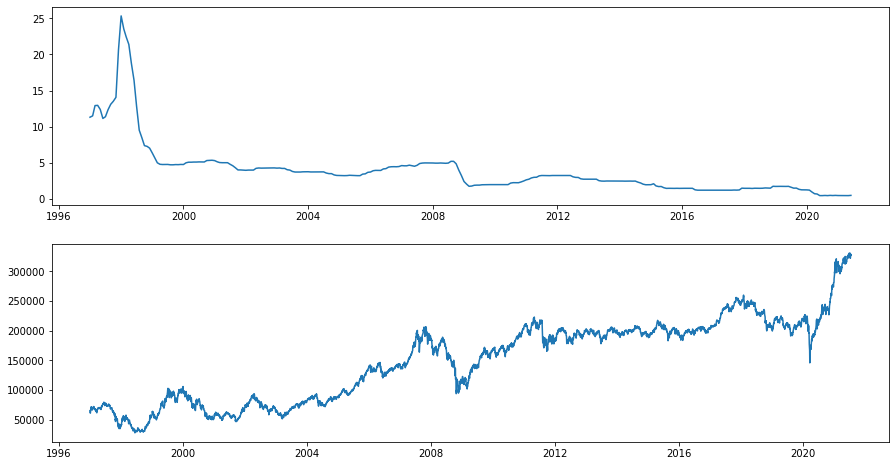

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2,figsize=(15,8))
axs[0].plot(ir_df['콜금리(평균)1일물'])
axs[1].plot(kospi_df['Close'])